# Natural Language Processing Intro

> Some of the examples in this notebook are adapted from the following sources:
> * NVIDIA DLI: [Building Transformer-Based Natural Language Processing Applications](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+C-FX-03+V3). This is an instructor-led course that I teach periodically--let me know if you have a group that would be interested in taking this workshop.
> * LinkedIn Learning: [Introduction to Transformer Models for NLP by Sinan Ozdemir](https://www.linkedin.com/learning/introduction-to-transformer-models-for-nlp/introduction). This is a great course, and like all LinkedIn Learning courses, is free to UF students, faculty and staff.


Natural Language Processing (NLP) is a large field of AI with many related but somewhat distinct sub-disciplines. We won't have time to look at all of these, but you are most likely somewhat familiar with many of the applications.

Some NLP Tasks:
* Summary generation, information extractions
* Translation (language to language)
* Transcription (speech to sample_text)
* Auto-completion
* Sentiment Analysis
* Intent Detection
* Voice assistant
* Document retrieval
* And the BIG one these days, **Chat**, automated writing, dialog generation, question answering, etc., the kinds of things that ChatGPT is known for. 

## Ambiguity in language

NLP is not a simple task, and until deep learning, was quite limited in its abilities. As with most fields in AI, there is a long history [dating back to the 1950s](https://en.wikipedia.org/wiki/Natural_language_processing). Part of the challenge is that human language tends to be ambiguous, and recognizing words is really only the start of inferring meaning. Take for example, this sentence:

   > The boy saw a man with a telescope
   
   * Who had the telescope?
   
More consample_text is needed to answer this. Yet, consample_text is not always there, and even when it is, it can be a challenge for NLP methods (and even human readers at times).

## Tokenization

One of the challenges of NLP is representing language as numbers--remember, computers and the ML/AI systems that we have primarily deal with numbers. This was relatively easy for computer vision problems because we took the pixel intensities of an image and fed those into our models. But what should we do with speech, words, and sample_text?

The process of converting sample_text to numerical representation is called **tokenization**. There are many methods of tokenization, but the idea is to break sample_text into itemizable components--tokens.

Tokens can be words, letters, word fragments, or even sentences.


## The BERT WordPiece Tokenizers

From the NVIDIA Course:
> Tokenization splits a word, phrase, or larger sample_text section into individual characters, words, or subwords.  For example, the word "tokenization" could be split in a number of ways:
>
> * Characters: 't', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n'
> * Words: 'tokenization'
> * Subwords: 'token', '##ization'
>
> The idea is to create a vocabulary of tokens from a sample_text corpus, which can then be trained in a language model to characterize language relationships between the tokens.  Whether this is done by character, word, or subword affects the complexity of the problem.
>
> Tokenization by characters has the advantage of a very limited number of tokens to deal with, but these few tokens are not very meaningful by themselves and long sequences of tokens are required to represent sample_text.  Tokenization by words results in a very large vocabulary size and requires separate tokens for very similar words, which in turn requires more training to determine their relationships to each other.
>
> Tokenization by subwords is a solution that tries to balance these two. For example, the word "token" is a subword for "tokenization", "tokens", and "tokenize".  By splitting the words, the model learns similar meanings from the same root word more easily.  The size of the overall vocabulary required for understanding is less than required for word tokenization.

## WordPiece Algorithm
> The WordPiece algorithm was introduced in [this paper by Schuster and Nakajima](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf).  To begin, the training data (corpus) is chosen, as well as the subword vocabulary size desired.   The algorithm iteratively determines optimal subwords for the body of sample_text and creates the vocabulary with assigned values.  The iterative steps are:
>
> 1. Split words into sequences of character tokens.
> 2. Build the language model on the training data using tokens from previous step.
> 3. Generate new unit tokens by combining two tokens with high likelihood in the language model and add the new token(s) to the vocabulary.
> 4. Repeat from step 2 until the token limit for the desired vocabulary is reached or the likelihood falls below some desired threshold.

Let's look at this in code...

In [1]:
# Import nemo nlp collection 
from nemo.collections import nlp as nemo_nlp

# Import BERT
from nemo.collections.nlp.models import BERTLMModel

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NeMo W 2025-03-20 12:14:39 nemo_logging:405] /opt/megatron-lm/megatron/core/transformer/cuda_graphs.py:741: SyntaxWarning: assertion is always true, perhaps remove parentheses?
      assert (
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNIN

In [2]:
# Check the list of pre-trained BERT language models
BERTLMModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=bertbaseuncased,
 	description=The model was trained EN Wikipedia and BookCorpus on a sequence length of 512.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/bertbaseuncased/versions/1.0.0rc1/files/bertbaseuncased.nemo
 ),
 PretrainedModelInfo(
 	pretrained_model_name=bertlargeuncased,
 	description=The model was trained EN Wikipedia and BookCorpus on a sequence length of 512.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/bertlargeuncased/versions/1.0.0rc1/files/bertlargeuncased.nemo
 )]

> There are two pretrained BERT language models available with NeMo: 
> - `bertbaseuncased` model has 110 millions parameters in total with 12 Transformer blocks.
> - `bertlargeuncased` model has 340 millions parameters in total with 24 Transformer blocks.
> 
> For the sake of time and simplicity, we'll download the smaller variant, BERT Base. This could take a minute or two.

In [4]:
# Download the pretrained BERT-based model
pretrained_model_name="bertbaseuncased"
model = BERTLMModel.from_pretrained(pretrained_model_name, strict=False) # Pass strict=False to avoid needing to specify
                                                                        # training parameters.

[NeMo I 2025-03-20 12:19:43 nemo_logging:393] Found existing object /home/magitz/.cache/torch/NeMo/NeMo_2.2.0rc4/bertbaseuncased/a88245d85161094369a11077be3e99be/bertbaseuncased.nemo.
[NeMo I 2025-03-20 12:19:43 nemo_logging:393] Re-using file from: /home/magitz/.cache/torch/NeMo/NeMo_2.2.0rc4/bertbaseuncased/a88245d85161094369a11077be3e99be/bertbaseuncased.nemo
[NeMo I 2025-03-20 12:19:43 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-03-20 12:19:48 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    data_file: /home/yzhang/data/nlp/bert/47316/hdf5/lower_case_1_seq_len_512_max_pred_80_masked_lm_prob_0.15_random_seed_12345_dupe_factor_5_shard_1472_test_split_10/books_wiki_en_corpus/training/
    max_predictions_per_seq: 80
    batch_size: 16
    shuffle: true
    num_samples: -1
    num_workers: 2
    drop_last: false
    pin_memory: false
    
[NeMo W 2025-03-20 12:19:48 nemo_logging:405] bert-base-uncased is not in get_pretrained_lm_models_list(include_external=False), will be using AutoModel from HuggingFace.
[NeMo W 2025-03-20 12:19:49 nemo_logging:405] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2025-03-20 12:19:49 nemo_logging:393] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 4.375e-05
        maximize: False
        weight_decay: 0.01
    )


[NeMo W 2025-03-20 12:19:49 nemo_logging:405] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2025-03-20 12:19:49 nemo_logging:393] Model BERTLMModel was successfully restored from /home/magitz/.cache/torch/NeMo/NeMo_2.2.0rc4/bertbaseuncased/a88245d85161094369a11077be3e99be/bertbaseuncased.nemo.


In [22]:
# Take a look at the number of weights in the model
print(f'Number of weights in {pretrained_model_name}: {model.num_weights}')

Number of weights in bertbaseuncased : 110697020


In [6]:
# Check available tokenizers
nemo_nlp.modules.get_tokenizer_list()

['sentencepiece',
 'char',
 'word',
 'cl-tohoku/bert-base-japanese-char-whole-word-masking',
 'distilbert/distilroberta-base',
 'openai-community/gpt2-medium',
 'openai-community/roberta-large-openai-detector',
 'cl-tohoku/bert-base-japanese-char',
 'albert/albert-large-v2',
 'wietsedv/bert-base-dutch-cased',
 'distilbert-base-uncased-finetuned-sst-2-english',
 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad',
 'google-bert/bert-base-uncased',
 'Musixmatch/umberto-commoncrawl-cased-v1',
 'FacebookAI/roberta-large',
 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'distilbert-base-german-cased',
 'albert/albert-large-v1',
 'google-bert/bert-large-cased-whole-word-masking',
 'google-bert/bert-large-uncased',
 'distilbert-base-uncased-distilled-squad',
 'google-bert/bert-base-german-dbmdz-uncased',
 'FacebookAI/roberta-base',
 'distilbert-base-cased-distilled-squad',
 'google-bert/bert-large-cased-whole-word-masking-finetuned-squad',
 'openai-community/roberta-base-

As I indicated, there are a lot of options on how to do tokenization...though in general, you will need to use what was used in training the model if you use a pre-trained model.

In [7]:
# Get the bert-base-uncased tokenizer 
tokenizer_uncased = nemo_nlp.modules.get_tokenizer(tokenizer_name="bert-base-uncased")

[NeMo I 2025-03-20 12:20:36 nemo_logging:393] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: None, merges_files: None, special_tokens_dict: {}, and use_fast: False


In [23]:
# Check the vocabulary size
print(f'The vocabulary size of {pretrained_model_name}: {tokenizer_uncased.vocab_size}')

The vocabulary size of bertbaseuncased: 30522


In [25]:
sample_sample_text = "Hello, my name is Matt. I live in Gainesville, FL."

In [26]:
output_uncased=tokenizer_uncased.sample_text_to_tokens(sample_sample_text)
print(f'Input sentence: {sample_sample_text}')
print(f'Tokenized sentence: {output_uncased}')

Input sentence: Hello, my name is Matt. I live in Gainesville, FL.
Tokenized sentence: ['hello', ',', 'my', 'name', 'is', 'matt', '.', 'i', 'live', 'in', 'gaines', '##ville', ',', 'fl', '.']


In [27]:
# Get the bert-base-cased tokenizer 
tokenizer_cased = nemo_nlp.modules.get_tokenizer(tokenizer_name="bert-base-cased")

[NeMo I 2025-03-20 12:40:53 nemo_logging:393] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-cased, vocab_file: None, merges_files: None, special_tokens_dict: {}, and use_fast: False


In [28]:
# Encode the sample_text 
output_cased=tokenizer_cased.sample_text_to_tokens(sample_sample_text)
print(f'Input sentence: {sample_sample_text}')
print(f'Tokenized sentence: {output_cased}')

Input sentence: Hello, my name is Matt. I live in Gainesville, FL.
Tokenized sentence: ['Hello', ',', 'my', 'name', 'is', 'Matt', '.', 'I', 'live', 'in', 'G', '##aines', '##ville', ',', 'FL', '.']


> The BERT model [or any NLP model really] does not accept sample_text inputs, but rather their numerical index representations.
>
> We can check the vocabulary index of a word using the `tokenizer.sample_text_to_ids()` function. 
>
> Try it with the `bert-base-cased` tokenizer.

In [31]:
# Index of the tokens Hello and hello using bert-base-cased tokenizer
print(f'Index of Hello: {tokenizer_cased.sample_text_to_ids("Hello")}')
print(f'Index of hello: {tokenizer_cased.sample_text_to_ids("hello")}')

Index of Hello: [8667]
Index of hello: [19082]


In [32]:
# Example of bert-base-cased tokenizer in a sentence
print(f'Input sentence: {sample_sample_text}')
print(f'Tokenized sentence: {output_cased}')
print(f'Tokenized sentence: {tokenizer_cased.sample_text_to_ids(sample_sample_text)}')

Input sentence: Hello, my name is Matt. I live in Gainesville, FL.
Tokenized sentence: ['Hello', ',', 'my', 'name', 'is', 'Matt', '.', 'I', 'live', 'in', 'G', '##aines', '##ville', ',', 'FL', '.']
Tokenized sentence: [8667, 117, 1139, 1271, 1110, 3895, 119, 146, 1686, 1107, 144, 25180, 2138, 117, 23485, 119]




## Embedding

The tokenization process takes care of converting words to numbers. This is a first step, but we want to consample_textualize the words--i.e., what does each word mean? Embedding goes a step further, representing words in n-dimensional vector space. This vector space has a lower dimensionality than the number of words in the vocabulary (as opposed to one-hot encoding) and results in words with similar meaning being closer in space than other words.

Here's an example figure showing some embeddings (taken from Renu Khandelwal's article [*Word Embeddings for NLP*](https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4):


![Image of word embeddings from https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4 ](images/word_embeddings_Renu_Khandelwal.png)

The embedding is learned in the training process. 

In [34]:
import torch

# Set up the sentence we want to look at
sample_text = "Last night, my wireless mouse was eaten by an animal such as a mouse or rat. I need to order a new optical computer mouse."
input_sentence=torch.tensor([tokenizer_uncased.tokenizer(sample_text).input_ids]).cuda()
attention_mask=torch.tensor([tokenizer_uncased.tokenizer(sample_text).attention_mask]).cuda()

In [49]:
# Show the tokenization for the sentence
print(f'Input sentence: {sample_text}')
output_uncased=tokenizer_uncased.ids_to_tokens(tokenizer_uncased.tokenizer(sample_text).input_ids)
print(f'Tokenized sentence: {output_uncased}')

# "mouse" tokens positions in the sample_text input
mouse_computer_1=6
mouse_animal=15
mouse_computer_2=27

print("Check that numbers line up:")
print(f'  Should be "mouse, mouse, mouse": {output_uncased[mouse_computer_1]}, {output_uncased[mouse_animal]}, {output_uncased[mouse_computer_2]}')


Input sentence: Last night, my wireless mouse was eaten by an animal such as a mouse or rat. I need to order a new optical computer mouse.
Tokenized sentence: ['[CLS]', 'last', 'night', ',', 'my', 'wireless', 'mouse', 'was', 'eaten', 'by', 'an', 'animal', 'such', 'as', 'a', 'mouse', 'or', 'rat', '.', 'i', 'need', 'to', 'order', 'a', 'new', 'optical', 'computer', 'mouse', '.', '[SEP]']
Check that numbers line up:
  Should be "mouse, mouse, mouse": mouse, mouse, mouse


In [50]:
# Get the embeddings for the pretrained model
hidden_states = model.bert_model(input_ids=input_sentence, token_type_ids=None, attention_mask=attention_mask)

In [51]:
from numpy import dot
from numpy.linalg import norm

def similarity_cosine(x,y):
    return dot(x,y)/(norm(x)*norm(y))

> We can visualize sample_text token embeddings obtained from the BERT models if we first reduce the dimensionality to 2D. 
[t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) is a dimensionality reduction technique widely used for vector visualization in 2D or 3D, as it preserves the neighborhood distances.
>
> The following codeblocks uses the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation of the t-SNE algorithm to reduce the dimensionality of BERT sample_text token embeddings from 768 to 2, and plots the 2D vectors. Note that as t-SNE is a stochastic process, the low dimensional embeddings will vary from one run to another. However, the neighborhood distances of tokens should remain more or less the same. 

In [52]:
from sklearn.manifold import TSNE
import numpy as np

X=hidden_states.cpu().detach().numpy()
X_embedded = TSNE(n_components=2,metric='euclidean',  init='random', perplexity=7).fit_transform(X[0])
Tokens=tokenizer_uncased.ids_to_tokens(tokenizer_uncased.tokenizer(sample_text).input_ids)

# Annotate the different mouse tokens
Tokens[mouse_computer_1]="mouse_computer_1"
Tokens[mouse_animal]="mouse_animal"
Tokens[mouse_computer_2]="mouse_computer_2"

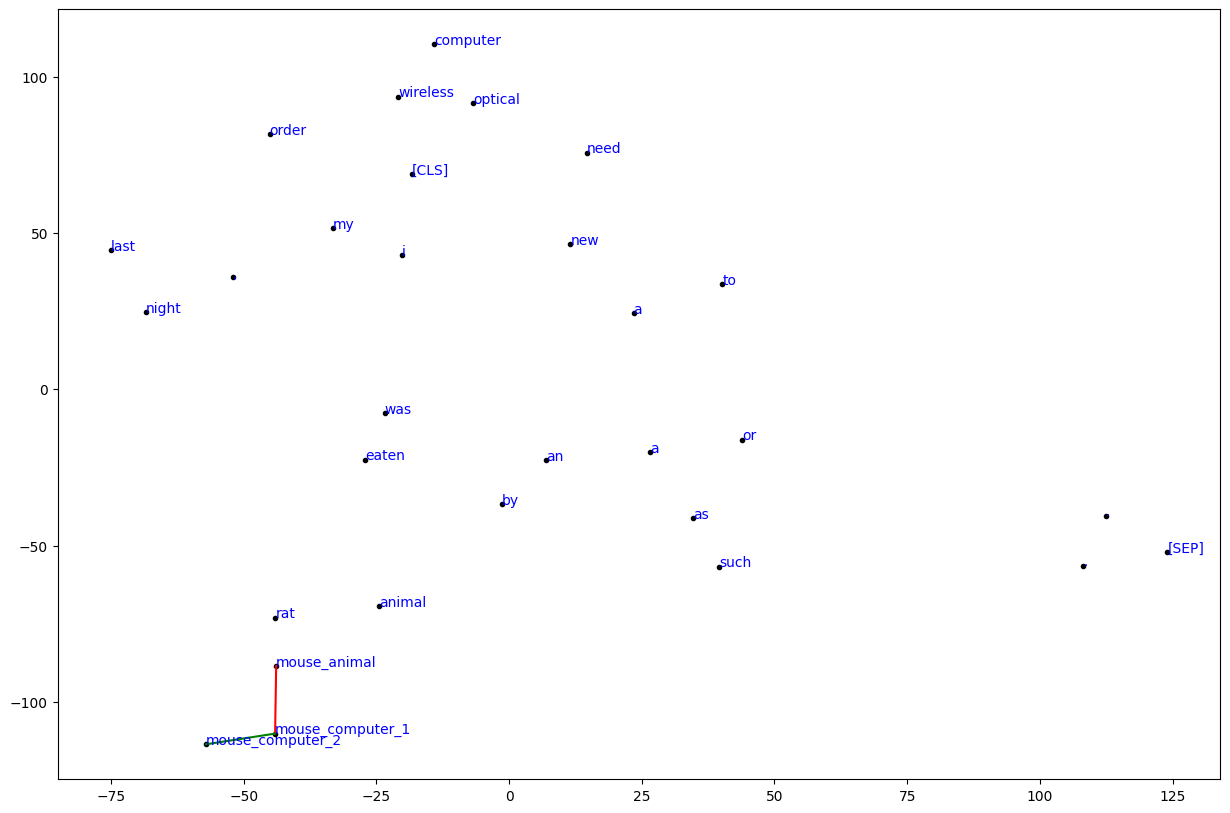

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,10))
plt.plot(X_embedded[:,0],X_embedded[:,1], '.', color='black')
plt.plot([X_embedded[mouse_computer_1,0],X_embedded[mouse_animal,0]],[X_embedded[mouse_computer_1,1],X_embedded[mouse_animal,1]],color='red')
plt.plot([X_embedded[mouse_computer_1,0],X_embedded[mouse_computer_2,0]],[X_embedded[mouse_computer_1,1],X_embedded[mouse_computer_2,1]],color='green')

for i, txt in enumerate(Tokens):
    plt.annotate(txt, (X_embedded[i,0], X_embedded[i,1]), color='blue')

## Build and fit the model

Our first layer is the embedding layer that learns to convert the numbered words in the vocabulary to the embedding. Then we have two LSTM layers and a dense layer with a ReLU activation and a final layer with one neuron per word in the vocabulary and a softmax to make the output the probability of each word being the output from the model.

In [ ]:
# Build and train model.
training_model = Sequential()
training_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, input_length=None))
training_model.add(LSTM(128, return_sequences=True,
                        dropout=0.2, recurrent_dropout=0.2))
training_model.add(LSTM(128, dropout=0.2,
                        recurrent_dropout=0.2))
training_model.add(Dense(128, activation='relu'))
training_model.add(Dense(MAX_WORDS, activation='softmax'))
training_model.compile(loss='categorical_crossentropy',
                       optimizer='adam')
training_model.summary()
history = training_model.fit(X, y, validation_split=0.05,
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, verbose=2, 
                             shuffle=True)

In [ ]:
# Build stateful model used for prediction.
inference_model = Sequential()
inference_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, batch_input_shape=(1, 1)))
inference_model.add(LSTM(128, return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2,
                         stateful=True))
inference_model.add(LSTM(128, dropout=0.2,
                         recurrent_dropout=0.2, stateful=True))
inference_model.add(Dense(128, activation='relu'))
inference_model.add(Dense(MAX_WORDS, activation='softmax'))
weights = training_model.get_weights()
inference_model.set_weights(weights)

In [ ]:
# Provide beginning of sentence and
# predict next words in a greedy manner
first_words = ['i', 'saw']
first_words_indexed = tokenizer.sample_texts_to_sequences(
    first_words)
inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_sample_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = inference_model.predict(x, verbose=0)[0]
print(predicted_string)

In [ ]:
# Let's predict more by changing predict length to 10

PREDICT_LENGTH = 10

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_sample_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = inference_model.predict(x, verbose=0)[0]
print(predicted_string)

In [ ]:
# Explore embedding similarities.
embeddings = training_model.layers[0].get_weights()[0]
lookup_words = ['the', 'saw', 'see', 'of', 'and',
                'monster', 'frankenstein', 'read', 'eat']
for lookup_word in lookup_words:
    lookup_word_indexed = tokenizer.sample_texts_to_sequences(
        [lookup_word])
    print('words close to:', lookup_word)
    lookup_embedding = embeddings[lookup_word_indexed[0]]
    word_indices = {}
    # Calculate distances.
    for i, embedding in enumerate(embeddings):
        distance = np.linalg.norm(
            embedding - lookup_embedding)
        word_indices[distance] = i
    # Print sorted by distance.
    for distance in sorted(word_indices.keys())[:5]:
        word_index = word_indices[distance]
        word = tokenizer.sequences_to_sample_texts([[word_index]])[0]
        print(word + ': ', distance)
    print('')